In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='sans-serif')

from tqdm import tqdm

import torch
import torch.distributions as dist
import h5py

from geobed import BED_discrete
import geobed.fwd_collection.raytracer as raytracer

from utils import *

/home/dstrutz/sshfs/Libs/GeoBED/geobed/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
N_x = 1000
N_z = 500

x_lim = np.array( (0, 1500) ) 
z_lim = np.array( (0,  600) ) 

x = np.linspace(x_lim[0], x_lim[1], N_x)
z = np.linspace(z_lim[0], z_lim[1], N_z)

dx = x[1]-x[0]
dz = z[1]-z[0]

# Define some receivers, first a spread in the horizontal

n_designs = 200

x_designs = torch.linspace(x[2], x[-2], n_designs)
z_designs = torch.ones_like(x_designs)
designs = torch.vstack((x_designs, z_designs)).T

In [4]:
mu1=torch.tensor([ 650.0, 500.0])
mu2=torch.tensor([ 850.0, 250.0])
mu_list = [mu1, mu2]

cov1 = construct_covmat(90, 3, 12.0)
cov2 = construct_covmat(90, 3, 12.0)
cov_list = [cov1, cov2]

mix = dist.Categorical(torch.tensor([0.3, 0.3]))
comp = dist.MultivariateNormal(torch.stack(mu_list,axis=0),
                            covariance_matrix=torch.stack(cov_list, axis=0))

prior_dist = dist.MixtureSameFamily(mix, comp)

n_visual = int(1e4)
visual_samples = prior_dist.sample((n_visual,))

In [5]:
def create_band_array(width, angle, background=0, band=1, x=None, z=None, center_x=0, center_z=0):
    # create a numpy array with constant background
    array = np.full((len(x), len(z)), background, dtype=np.float32)
    # calculate the slope and intercept of the band line in meters
    slope = np.tan(np.radians(angle))
    
    intercept = (center_z) - slope * (center_x)
    # loop through the array and fill the band with the specified value
    for i in range(len(x)):
        for j in range(len(z)):
            # calculate the distance from the point to the line in meters
            distance = abs(slope * x[i] - z[j] + intercept) / np.sqrt(slope ** 2 + 1)
            # if the distance is less than or equal to the width, set the value to the band value
            if distance <= width:
                array[i, j] = band
    # return the array
    return array[:, ::-1]

250 750


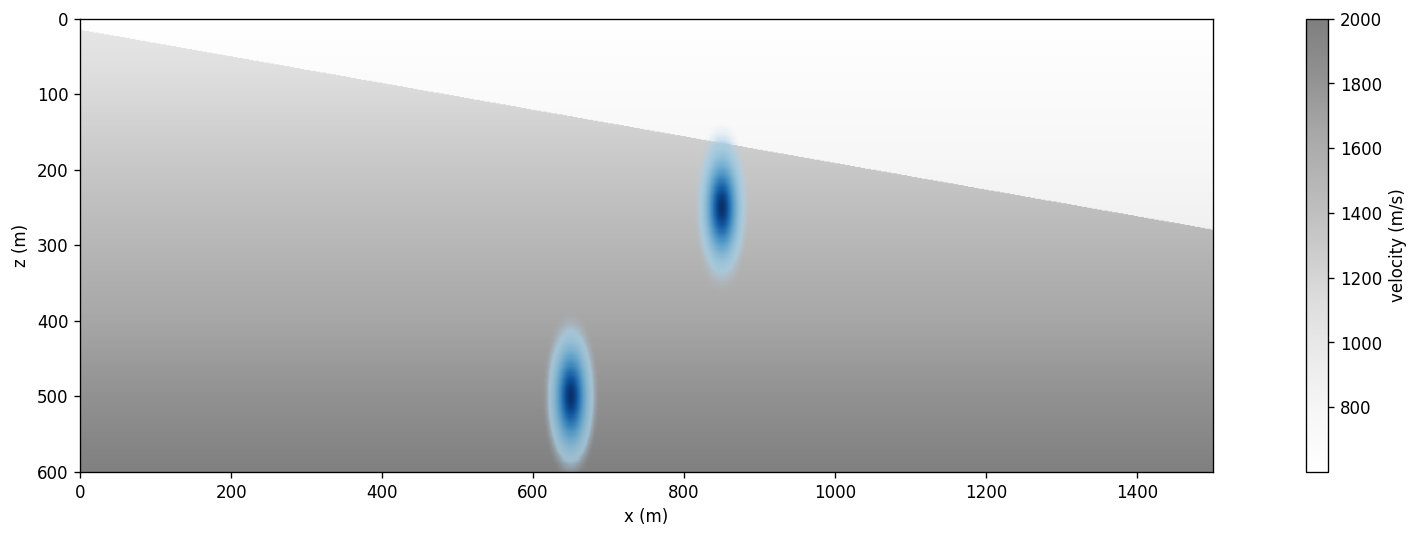

In [6]:
from matplotlib.colors import LinearSegmentedColormap

slowness = slowness_grid(x, z, method='gradient', v_top=1000.0, v_bottom=2000.0, coarsness=1, edges=False)
# velocity = 1/slowness

print(N_x//4, 3*N_x//4)
width = 200.0
angle=-10.0

fault_zone = create_band_array(width, angle, 1.0, 0.6, x=x,  z=z, center_x=500.0, center_z=700)

# plt.imshow(fault_zone.T)
# plt.show()

velocity = 1/slowness*fault_zone


# plt.imshow(slow_mask.T, origin='lower')
# plt.show()

# velocity[N_x//4:3*N_x//4, :N_z//5] *= 0.2
# velocity[slow_mask] *= 0.4

fig, ax = plt.subplots(figsize=(20, 5))

col = ax.imshow(velocity.T, extent=[x[0], x[-1], z[0], z[-1]], cmap='Greys', origin='lower', alpha=0.5)
cbar = fig.colorbar(col, ax=ax)
cbar.set_label('velocity (m/s)')
cbar.ax.invert_xaxis()

prior_grid_X, prior_grid_Z = torch.meshgrid(torch.linspace(x_lim[0], x_lim[1], 4000),
                            torch.linspace(z_lim[0], z_lim[1], 400),
                            indexing='ij')
prior_grid = torch.vstack((prior_grid_X.reshape(-1), prior_grid_Z.reshape(-1))).T
prior_pdf  = torch.exp(prior_dist.log_prob(prior_grid).reshape(4000, 400)).numpy()

color_array = plt.get_cmap('Blues')(np.arange(256))
alpha_offset = 80
color_array[:,-1] = np.concatenate((np.zeros(alpha_offset), np.linspace(0.0, 0.8, 10), np.linspace(0.8, 1.0, 256-alpha_offset-10)), axis=0)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array[alpha_offset-1:])

ax.pcolormesh(prior_grid_X, prior_grid_Z, prior_pdf, cmap=map_object, rasterized=True)  

ax.set_ylim(z_lim)
ax.invert_yaxis()

ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')

# ax.scatter(visual_samples[:, 0], visual_samples[:, 1], marker='x', color='b', s=10, alpha=0.1,
#            label='prior samples')

plt.gcf().set_dpi(120)
plt.show()

In [7]:
n_prior = int(2e5)
torch.manual_seed(0)
prior_samples = prior_dist.sample((n_prior,))


tt_H = raytracer.TTHelper()
tt_H.set_model( 
    x= x,  z=z,
    dx=dx, dz=dz,
    velocity_model=velocity)

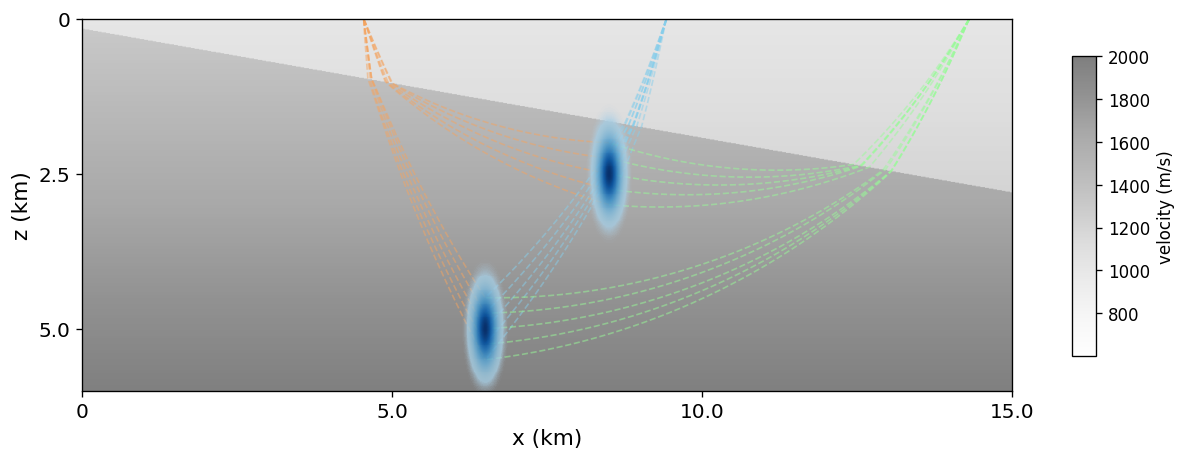

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.imshow(velocity.T, extent=[x[0]/1e3, x[-1]/1e3, z[0]/1e3, z[-1]/1e3], cmap='Greys', origin='lower', alpha=0.5, zorder=-10, vmin=0, vmax=2000)

prior_grid_X, prior_grid_Z = torch.meshgrid(torch.linspace(x_lim[0], x_lim[1], 4000),
                            torch.linspace(z_lim[0], z_lim[1], 400),
                            indexing='ij')
prior_grid = torch.vstack((prior_grid_X.reshape(-1), prior_grid_Z.reshape(-1))).T
prior_pdf  = torch.exp(prior_dist.log_prob(prior_grid).reshape(4000, 400)).numpy()

color_array = plt.get_cmap('Blues')(np.arange(256))
alpha_offset = 80
color_array[:,-1] = np.concatenate((np.zeros(alpha_offset), np.linspace(0.0, 0.8, 10), np.linspace(0.8, 1.0, 256-alpha_offset-10)), axis=0)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array[alpha_offset-1:])

ax.pcolormesh(prior_grid_X/1e3, prior_grid_Z/1e3, prior_pdf, cmap=map_object, rasterized=True, zorder=-4)  

# visualisation_samples = np.array([
#     [650.0, 450.0], [650.0, 470.0], [650.0, 490.0], [650.0, 510.0], [650.0, 530.0], [650.0, 550.0],
#     [850.0, 200.0], [850.0, 220.0], [850.0, 240.0], [850.0, 260.0], [850.0, 280.0], [850.0, 300.0],
# ])

n_ray_sampels = 5

visualisation_samples = torch.concatenate([
    torch.stack([torch.ones(n_ray_sampels)*650.0, torch.linspace(450.0, 550.0, n_ray_sampels)], dim=1),
    torch.stack([torch.ones(n_ray_sampels)*850.0, torch.linspace(200.0, 300.0, n_ray_sampels)], dim=1),
], dim=0)

lstyle = '--'
msize = 2.0
ray_alpha = 0.5

tt_H.plot_model(
    # prior_realisations=prior_samples[:1000].double().numpy(), 
    receivers=visualisation_samples,
    im_cmap=None,
    plot_rays=(designs[60, 0], designs[60, 1]),
    receiver_alpha=0.0,
    ax=ax,
    ray_kwargs={'color': 'sandybrown', 'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
)

tt_H.plot_model(
    # prior_realisations=prior_samples[:1000].double().numpy(), 
    receivers=visualisation_samples,
    im_cmap=None,
    plot_rays=(designs[125, 0], designs[25, 1]),
    receiver_alpha=0.0,
    ax=ax,
    ray_kwargs={'color': 'skyblue', 'alpha':  ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
)

tt_H.plot_model(
    # prior_realisations=prior_samples[:1000].double().numpy(), 
    receivers=visualisation_samples,
    im_cmap=None,
    plot_rays=(designs[190, 0], designs[190, 1]),
    receiver_alpha=0.0,
    ax=ax,
    ray_kwargs={'color': 'palegreen', 'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
)


ax.set_ylim((0.0, 0.6))
ax.set_yticks([0.0, 0.25, 0.5])
ax.set_yticklabels([0, 2.5, 5.0])

ax.set_xticks([0.0, 0.5, 1.0, 1.5])
ax.set_xticklabels([0, 5.0, 10.0, 15.0])

ax.set_xlabel('x (km)')
ax.set_ylabel('z (km)')

ax.invert_yaxis()

cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])
cbar = fig.colorbar(col, cax=cbar_ax)
cbar.set_label('velocity (m/s)')
cbar.ax.invert_xaxis()

plt.gcf().set_dpi(120)
plt.show()

In [9]:
print(min(velocity.flatten()), max(velocity.flatten()))

600.0000238418579 2000.0


In [10]:
test = tt_H.calculate_tt_diff((1000.0, 200.0), designs[::18].numpy())
print(test)

[0.60565586 0.55164911 0.49563968 0.43809828 0.37973976 0.32125888
 0.26348091 0.21183725 0.22394311 0.30237795 0.39083384 0.47624104]


In [11]:
core_name = f'break_dn_gradient_with_inclinded_layer_angle_{int(angle)}_thickness_{int(width)-100}'

filename = f'data/break_dn/lookup_table_{core_name}.h5'

prior_samples = calculate_traveltime_table(x, z, velocity, prior_samples, designs, filename, n_parallel=10)

In [12]:
with h5py.File(filename, 'r') as f:
    traveltime_table = f['data'][...]
    prior_samples = f['prior'][...]
    
print(traveltime_table.shape, prior_samples.shape)

(199757, 200, 1) (199757, 2)


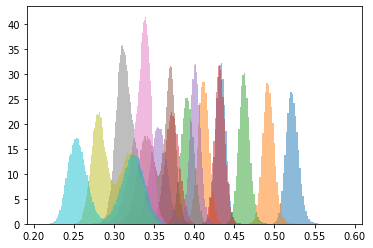

In [13]:
for i in range(0, 100, 10):
    plt.hist(traveltime_table[:, i, 0], bins=100, alpha=0.5, density=True)
plt.show()

In [14]:
n_design_points = n_designs
design_names = [str(i) for i in range(n_design_points)]

design_dicts = {} 

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'x': designs[i, 0], 'z': designs[i, 0], 'file': filename, 'dataset': 'data', 'cost': 1.0}

In [15]:
def data_likelihood(data, **kwargs):
    # Abakumov et al 2020
    std_model = 0.01
    return dist.Independent(dist.Normal(data, std_model), 1)

In [16]:
BED_class = BED_discrete(design_dicts, data_likelihood,
                         prior_samples=prior_samples, prior_dist=prior_dist,
                         design2data='lookup_1to1_fast')

Entropy of prior distribution could not be calculated. Calculating it numerically.                       Any errors will have no effect on the design optimisation.


In [17]:
n_visual = int(1e5)

clean_data = BED_class.get_forward_samples(design_names, n_samples=n_visual)
noisy_data = BED_class.get_likelihood_samples(design_names, n_samples=n_visual)

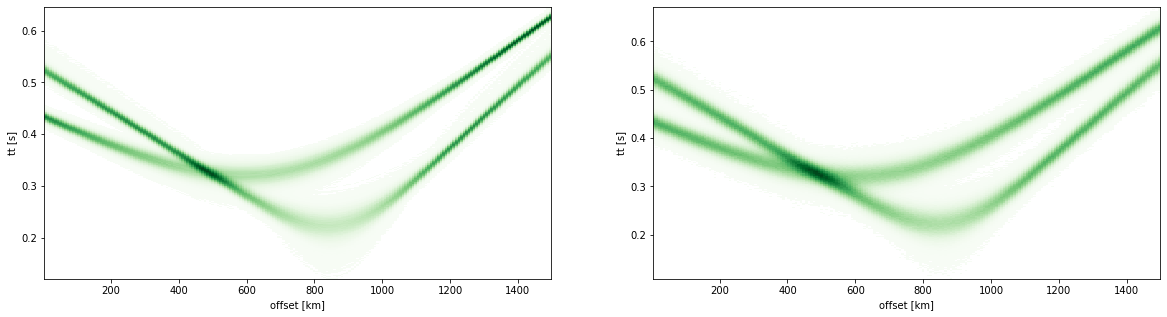

In [18]:
fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    clean_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(designs[:, 0].expand(n_visual, -1).flatten().numpy(),
                    noisy_data.flatten().numpy(),
                    bins=[n_designs, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set_ylabel('tt [s]')
ax_dict['b'].set_ylabel('tt [s]')

ax_dict['a'].set_xlabel('offset [km]')
ax_dict['b'].set_xlabel('offset [km]')


# fig.savefig(f'../figures/datadist_gmm_prior.pdf', bbox_inches='tight', dpi=150)
# fig.savefig(f'../figures/datadist_gmm_prior.png', bbox_inches='tight', dpi=150)
                        
plt.show()

In [19]:
optimal_design_dict = {}
info_dict = {}

In [20]:
design_budget = 2
n_parallel = 40

In [21]:
method = 'nmc'

M = int(1e4)
N = int(1e4)

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='nmc',
    eig_method_kwargs={'N': N, 'M': M, 'reuse_M_samples':True, 'memory_efficient':True},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/break_dn/{core_name}_{method}.pkl',
    )

# print(info_dict[method][1]['eig'])

In [22]:
method = 'dn'

N = int(1e4)

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method='dn',
    eig_method_kwargs={'N': N},
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/break_dn/{core_name}_{method}.pkl',
    )

In [23]:
from geobed.guides import GMM_guide

method = 'variational_marginal'

T = int(1e4)

N = int(T * 0.2)
M = int(T * 0.8)

n_grad_steps = 5000

def n_batch_schedule(M, **kwargs):
    return 50

def n_epochs_schedule(M, n_batch, **kwargs):
    return max(min(100, (n_grad_steps*n_batch)//(M)), 4)

def scheduler_step_size_schedule(n_epochs, **kwargs):
    return n_epochs//3

n_batch = n_batch_schedule(**{'M':M})
n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
print(n_batch, n_epochs, step_size)

scheduler = torch.optim.lr_scheduler.StepLR

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs=
     {'guide': GMM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'components':10},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-2},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': False,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/break_dn/{core_name}_{method}.pkl',
)

50 31 10


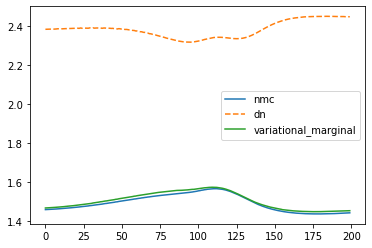

In [24]:
i_rec = 2

plt.plot(info_dict['nmc'][i_rec]['eig'], label='nmc')
plt.plot(info_dict['dn'][i_rec]['eig'], label='dn', linestyle='--')
plt.plot(info_dict['variational_marginal'][i_rec]['eig'], label='variational_marginal')

plt.legend()

plt.show()

In [25]:
n_rec = 2

nmc_design = optimal_design_dict['nmc'][:n_rec]
dn_design = optimal_design_dict['dn'][:n_rec]
vm_design = optimal_design_dict['variational_marginal'][:n_rec]

nmc_design_offsets = torch.tensor([design_dicts[d]['x'] for d in nmc_design])
dn_design_offsets = torch.tensor([design_dicts[d]['x'] for d in dn_design])
vm_design_offsets = torch.tensor([design_dicts[d]['x'] for d in vm_design])


[111, 112, 125, 183]


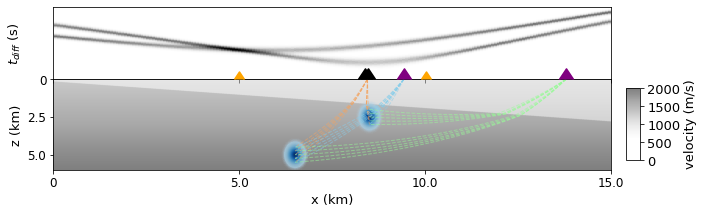

In [42]:
#set matplotlib fontsize to 13
with plt.rc_context({'axes.labelsize': 13, 'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.fontsize': 10}):

    fig = plt.figure(figsize=(10, 4))
    ax_dict = fig.subplot_mosaic(
        '''
        c
        d''', gridspec_kw={'height_ratios': [0.8, 1], 'hspace':0.0},
        sharex=True,)

    ax_dict['c'].hist2d((designs[:, 0]/1e3).expand(n_visual, -1).flatten().numpy(),
                        noisy_data.flatten().numpy(),
                        bins=[n_designs, 400], cmap='Greys', cmin=1)
        
    ax_dict['c'].set_ylim([0.8*noisy_data.min(), 1.0*noisy_data.max()])
    ax_dict['c'].set_yticks([])
    ax_dict['c'].set_ylabel(r'$t_{diff}$ (s)', labelpad=30)

    ax = ax_dict['d']

    ax.imshow(velocity.T, extent=[x[0]/1e3, x[-1]/1e3, z[0]/1e3, z[-1]/1e3], cmap='Greys', origin='lower', alpha=0.5, zorder=-10, vmin=0, vmax=2000, aspect='auto')
    ax.pcolormesh(prior_grid_X/1e3, prior_grid_Z/1e3, prior_pdf, cmap=map_object, rasterized=True, zorder=-9)  

    n_ray_sampels = 5

    visualisation_samples = torch.concatenate([
        torch.stack([torch.ones(n_ray_sampels)*650.0, torch.linspace(450.0, 550.0, n_ray_sampels)], dim=1),
        torch.stack([torch.ones(n_ray_sampels)*850.0, torch.linspace(200.0, 300.0, n_ray_sampels)], dim=1),
    ], dim=0)

    lstyle = '--'
    msize = 2.0
    ray_alpha = 0.5

    all_designs = nmc_design + dn_design
    all_designs = [int(d) for d in all_designs]
    
    print(all_designs)
    
    kwarg_list = [
        {'color': 'sandybrown', 'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
        {'color': 'skyblue',    'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
        {'color': 'palegreen',  'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
    ]
        

    for i, d in enumerate(all_designs[1:]):

        tt_H.plot_model(
            # prior_realisations=prior_samples[:1000].double().numpy(), 
            receivers=visualisation_samples,
            im_cmap=None,
            plot_rays=(designs[int(d), 0], designs[int(d), 1]),
            receiver_alpha=0.0,
            ax=ax,
            ray_kwargs=kwarg_list[i],
        )

    ax.scatter(designs[[int(d) for d in nmc_design], 0]/1e3, torch.zeros(2), marker=10, s=200, color='k', clip_on=False, zorder=100)
    ax.scatter(designs[[int(d) for d in dn_design], 0]/1e3, torch.zeros(2), marker=10, s=200, color='purple', clip_on=False, zorder=100)

    equi_design = [['66', '133']]
    ax.scatter(
        designs[[int(d) for d in equi_design[0]], 0]/1e3, torch.zeros(2), marker=10, s=100, color='orange', clip_on=False, zorder=100,)

    ax.set_ylim((0.0, 0.6))
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels([0, 2.5, 5.0])

    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')

    ax.invert_yaxis()

    cbar_ax = fig.add_axes([0.92, 0.17, 0.02, 0.6/1.8])
    cbar = fig.colorbar(col, cax=cbar_ax)
    cbar.set_label('velocity (m/s)')
    cbar.set_ticks([0, 500, 1000, 1500, 2000])
    cbar.ax.invert_xaxis()

    for ax_name in ax_dict.keys():
        ax_dict[ax_name].set_xticks([0.0, 0.5, 1.0, 1.5])
        ax_dict[ax_name].set_xticklabels([0, 5.0, 10.0, 15.0])

        # transparent background
        ax_dict[ax_name].patch.set_alpha(0.0)

    fig.savefig(f'figures/break_dn/break_dn_setup_evidence.pdf', bbox_inches='tight', dpi=150, transparent=True)
    fig.savefig(f'figures/break_dn/break_dn_setup_evidence.png', bbox_inches='tight', dpi=150, transparent=True)
                            
    plt.show()

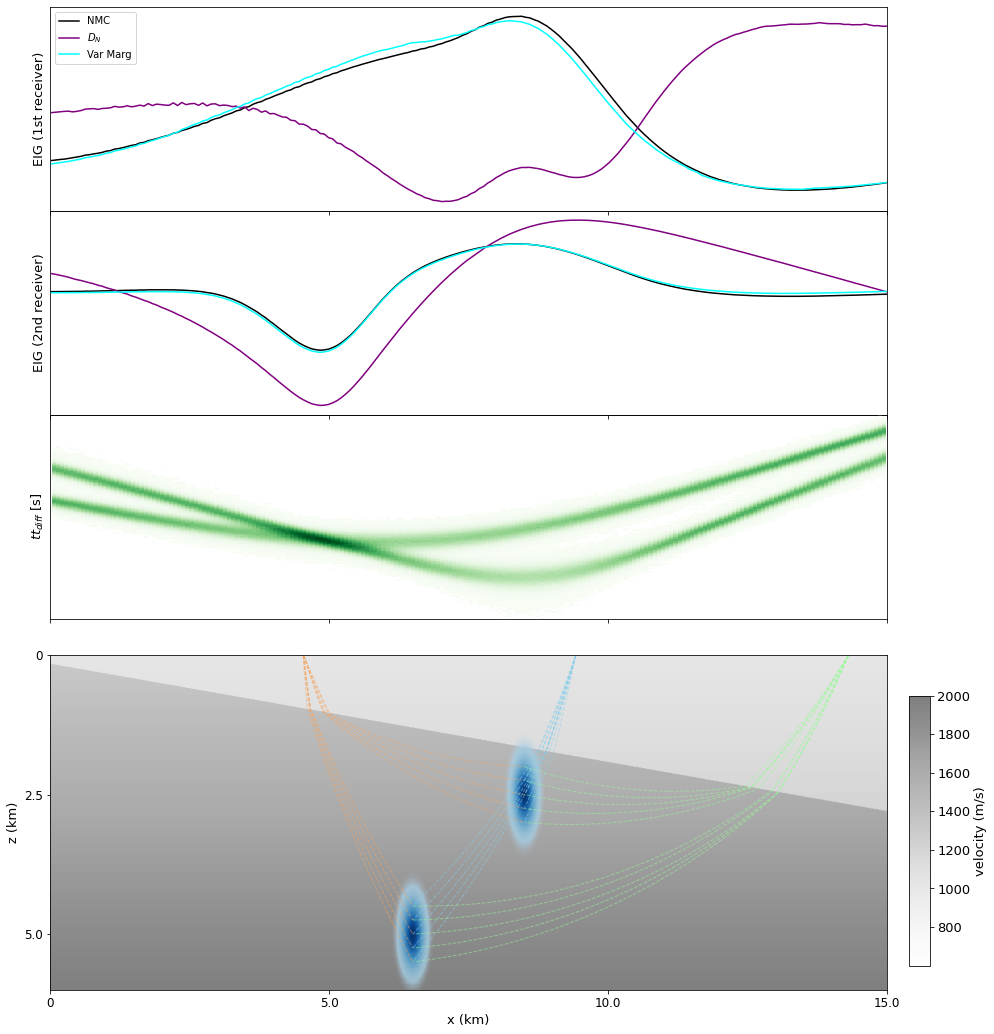

In [27]:
#set matplotlib fontsize to 13
with plt.rc_context({'axes.labelsize': 13, 'xtick.labelsize': 13, 'ytick.labelsize': 13, 'legend.fontsize': 10}):

    fig = plt.figure(figsize=(15, 12.5*1.5))
    ax_dict = fig.subplot_mosaic(
        '''a
        b
        c
        d''', gridspec_kw={'height_ratios': [0.5, 0.5, 0.5, 1], 'hspace':0.0},
        sharex=True,)

    i_rec = 1
    ax_dict['b'].plot(designs[:, 0]/1e3, info_dict['nmc'][i_rec]['eig'] - info_dict['nmc'][i_rec]['eig'].mean(), label='NMC', color='k')
    ax_dict['b'].plot(designs[:, 0]/1e3, info_dict['dn'][i_rec]['eig'] - info_dict['dn'][i_rec]['eig'].mean(), label=r'$D_N$', color='purple')
    ax_dict['b'].plot(designs[:, 0]/1e3, info_dict['variational_marginal'][i_rec]['eig'] - info_dict['variational_marginal'][i_rec]['eig'].mean(), label='Var Marg', color='cyan')
    ax_dict['b'].set_yticks([])
    ax_dict['b'].set_ylabel('EIG (2nd receiver)')

    i_rec = 2
    ax_dict['a'].plot(designs[:, 0]/1e3, info_dict['nmc'][i_rec]['eig'] - info_dict['nmc'][i_rec]['eig'].mean(), label='NMC', color='k')
    ax_dict['a'].plot(designs[:, 0]/1e3, info_dict['dn'][i_rec]['eig'] - info_dict['dn'][i_rec]['eig'].mean(), label=r'$D_N$', color='purple')
    ax_dict['a'].plot(designs[:, 0]/1e3, info_dict['variational_marginal'][i_rec]['eig'] - info_dict['variational_marginal'][i_rec]['eig'].mean(), label='Var Marg', color='cyan')
    ax_dict['a'].set_ylabel('EIG (1st receiver)')

    ax_dict['a'].set_yticks([])
    ax_dict['a'].legend()

    ax_dict['c'].hist2d((designs[:, 0]/1e3).expand(n_visual, -1).flatten().numpy(),
                        noisy_data.flatten().numpy(),
                        bins=[n_designs, 400], cmap='Greens', cmin=1)
        
    ax_dict['c'].set_yticks([])
    ax_dict['c'].set_ylabel(r'$tt_{diff}$ [s]')

    ax = ax_dict['d']

    ax.imshow(velocity.T, extent=[x[0]/1e3, x[-1]/1e3, z[0]/1e3, z[-1]/1e3], cmap='Greys', origin='lower', alpha=0.5, zorder=-10, vmin=0, vmax=2000)
    ax.pcolormesh(prior_grid_X/1e3, prior_grid_Z/1e3, prior_pdf, cmap=map_object, rasterized=True, zorder=-9)  

    n_ray_sampels = 5

    visualisation_samples = torch.concatenate([
        torch.stack([torch.ones(n_ray_sampels)*650.0, torch.linspace(450.0, 550.0, n_ray_sampels)], dim=1),
        torch.stack([torch.ones(n_ray_sampels)*850.0, torch.linspace(200.0, 300.0, n_ray_sampels)], dim=1),
    ], dim=0)

    lstyle = '--'
    msize = 2.0
    ray_alpha = 0.5

    


    tt_H.plot_model(
        # prior_realisations=prior_samples[:1000].double().numpy(), 
        receivers=visualisation_samples,
        im_cmap=None,
        plot_rays=(designs[60, 0], designs[60, 1]),
        receiver_alpha=0.0,
        ax=ax,
        ray_kwargs={'color': 'sandybrown', 'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
    )

    tt_H.plot_model(
        # prior_realisations=prior_samples[:1000].double().numpy(), 
        receivers=visualisation_samples,
        im_cmap=None,
        plot_rays=(designs[125, 0], designs[25, 1]),
        receiver_alpha=0.0,
        ax=ax,
        ray_kwargs={'color': 'skyblue', 'alpha':  ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
    )

    tt_H.plot_model(
        # prior_realisations=prior_samples[:1000].double().numpy(), 
        receivers=visualisation_samples,
        im_cmap=None,
        plot_rays=(designs[190, 0], designs[190, 1]),
        receiver_alpha=0.0,
        ax=ax,
        ray_kwargs={'color': 'palegreen', 'alpha': ray_alpha, 'linewidth': 1.0, 'linestyle': lstyle, 'markersize': msize, 'zorder':-5},
    )

    ax.set_ylim((0.0, 0.6))
    ax.set_yticks([0.0, 0.25, 0.5])
    ax.set_yticklabels([0, 2.5, 5.0])

    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (km)')

    ax.invert_yaxis()

    cbar_ax = fig.add_axes([0.92, 0.17, 0.02, 0.5/2.5])
    cbar = fig.colorbar(col, cax=cbar_ax)
    cbar.set_label('velocity (m/s)')
    cbar.ax.invert_xaxis()

    for ax_name in ax_dict.keys():
        ax_dict[ax_name].set_xticks([0.0, 0.5, 1.0, 1.5])
        ax_dict[ax_name].set_xticklabels([0, 5.0, 10.0, 15.0])

        # transparent background
        ax_dict[ax_name].patch.set_alpha(0.0)

    fig.savefig(f'figures/break_dn/break_dn_summary_figure.pdf', bbox_inches='tight', dpi=150, transparent=True)
    fig.savefig(f'figures/break_dn/break_dn_summary_figure.png', bbox_inches='tight', dpi=150, transparent=True)
                            
    plt.show()

In [28]:
optimal_design_dict

{'nmc': ['111', '112'],
 'dn': ['125', '183'],
 'variational_marginal': ['112', '109']}

In [29]:
M = int(1e4)
N = int(1e4)

comp_list = []

equi_design = [['66', '133'], ['0', '199'],]

comp_list.append(optimal_design_dict['nmc'])
comp_list.append(optimal_design_dict['dn'])
comp_list.append(optimal_design_dict['variational_marginal'])
comp_list += equi_design

comp_eig, comp_info = BED_class.calculate_eig_list(
    design_list=comp_list,
    method='nmc',
    method_kwargs={'N': N, 'M': M, 'reuse_M_samples':True},
    num_workers=n_parallel,
    filename=f'data/break_dn/{core_name}_benchmark_methods.pkl',
    )

In [30]:
print(comp_eig)

tensor([1.5664, 1.3580, 1.5660, 1.4009, 1.0580])


In [31]:
random_designs = np.random.choice(design_names, size=(1000, 2)).tolist()

N = int(1e4)
M = int(1e4)

random_eig, random_info = BED_class.calculate_eig_list(
    design_list=random_designs,
    method='nmc',
    method_kwargs={'N': N, 'M': M, 'reuse_M_samples':True, 'memory_efficient': True},
    num_workers=n_parallel,
    progress_bar=True,
    filename=f'data/break_dn/{core_name}_benchmark_random.pkl',
    )

In [32]:
print(comp_eig)

print(random_eig.mean(), random_eig.std(), random_eig.min(), random_eig.max())

tensor([1.5664, 1.3580, 1.5660, 1.4009, 1.0580])
tensor(1.2444) tensor(0.1780) tensor(0.5894) tensor(1.5676)


In [33]:
import seaborn as sns

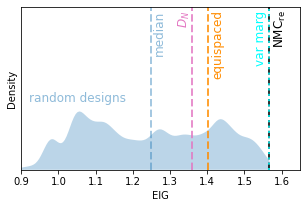

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# ax.hist(random_eig, bins=40, density=True, label='random designs', range=(0.9, 1.4), alpha=0.5)
sns.kdeplot(random_eig, ax=ax, label='random designs', 
            color='tab:blue', linewidth=0, alpha=0.3, bw_adjust=0.4, cut=0,
            fill=True)

ax.set_xlim([0.9, 1.65])

ax.set_ylim([0, 7.0])
vertical_offset = ax.get_ylim()[1] * 0.98

fontsize = 12
ymin = 0.0
lw=2.0

ax.axvline(comp_eig[0], ymin=ymin, color='k' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
ax.text(comp_eig[0]+0.01, vertical_offset, r'$\mathrm{NMC}_\mathrm{re}$', rotation=90, color='k', fontsize=fontsize, verticalalignment='top')

ax.axvline(comp_eig[1], ymin=ymin, color='tab:pink', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
ax.text(comp_eig[1]-0.04, vertical_offset, r'$D_N$', rotation=90, color='tab:pink', fontsize=fontsize, verticalalignment='top')

ax.axvline(comp_eig[2], ymin=ymin, color='cyan', linewidth=lw, linestyle=':', alpha=0.8, zorder=1,)
ax.text(comp_eig[2]-0.04, vertical_offset, 'var marg', rotation=90, color='cyan', fontsize=fontsize, verticalalignment='top')

ax.axvline(comp_eig[3], ymin=ymin, color='darkorange' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1)
ax.text(comp_eig[3]+0.01, vertical_offset, 'equispaced', rotation=90, color='darkorange', fontsize=fontsize, verticalalignment='top', )
# ax.axvline(comp_eig[4], ymin=ymin, color='gold' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1)
# ax.text(comp_eig[4]+0.005, vertical_offset, 'equispaced', rotation=90, color='gold', fontsize=fontsize, verticalalignment='top', )

median_eig = np.median(random_eig)
ax.axvline(median_eig, ymin=ymin, color='tab:blue' , linewidth=lw, linestyle='--', alpha=0.4, zorder=1)
ax.text(median_eig+0.005, vertical_offset, 'median', rotation=90, color='tab:blue', fontsize=fontsize, verticalalignment='top', alpha=0.5,)

ax.text(0.92, vertical_offset*0.45, 'random designs', rotation=0, color='tab:blue',
        fontsize=fontsize, verticalalignment='center', alpha=0.5, )

ax.set_ylabel('Density')
ax.set_yticks([])

ax.set_xlabel('EIG')

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

fig.savefig('figures/break_dn/break_dn_eig_comparison.pdf', bbox_inches='tight', transparent=True, dpi=150)
fig.savefig('figures/break_dn/break_dn_eig_comparison.png', bbox_inches='tight', transparent=True, dpi=150)

plt.show()

In [35]:
import math

std_nmc = math.sqrt(math.exp(2 * comp_eig[0]) / ((2 * math.pi * math.e)**(2)))
std_dn = math.sqrt(math.exp(2 * comp_eig[1]) / ((2 * math.pi * math.e)**(2)))
std_var = math.sqrt(math.exp(2 * comp_eig[2]) / ((2 * math.pi * math.e)**(2)))

std_heu_1 = math.sqrt(math.exp(2 * comp_eig[3]) / ((2 * math.pi * math.e)**(2)))
std_heu_2 = math.sqrt(math.exp(2 * comp_eig[4]) / ((2 * math.pi * math.e)**(2)))

print(f'NMC: {std_dn:.4f}')
print(f'D_N: {std_nmc:.4f}')
print(f'variational marginal: {std_var:.4f}')
print(f'heuristic designs: {std_heu_1:.4f}, {std_heu_2:.4f}')

NMC: 0.2277
D_N: 0.2804
variational marginal: 0.2803
heuristic designs: 0.2377, 0.1687
